+ This note offers a snippet of Soft-Actor Critic implemented on tf_agents.
    + Sac agents are trained to control environments representing the first-order delay system.
    + The episodes of environments must stop by a certain iteration, which means that this task is featured as an episodic-MDP.

In [1]:
from datetime import datetime
import numpy as np
import tensorflow as tf

from tf_agents.agents.sac import sac_agent
from tf_agents.agents.tf_agent import TFAgent
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.replay_buffers.replay_buffer import ReplayBuffer
from tf_agents.specs import array_spec
from tf_agents.train.utils import train_utils
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories.time_step import TimeStep

In [2]:
class MyEnv(py_environment.PyEnvironment):
    '''
    
    Y(s) = K/(1+T*s) * U(s)
    
    T * dy(t)/dt = - y(t) + K * u(t), t > 0, 
    y(0) = y_init.
    
    y(t+1) = (1-1/T) * y(t) + K / T * u(t), t = 1,2, ...
    y(0) = y_init.
    '''

    def __init__(self, discount, T = 10, K = 1.0, maxIteration = None, sv = 0.5, dv = 0.1):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.float32, minimum=(-1,), maximum=(1,), name='action')

        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.float32, minimum=(-1,), maximum=(1,), name='observation')

        assert maxIteration is None
        
        self._state = self.getInitialState()
        self._episode_ended = False
        self.time = 0
        self.T = T
        self.K = K
        self.discount = discount
        self.sv = sv
        self.dv = dv
        self.beta = np.sqrt(1 - (1-1/T)**2)
    
    def getInitialState(self):
        return 0.0
    
    def getObservation(self):
        return np.array((self._state,), np.float32) # (1,)
    
    def action_spec(self):
        return self._action_spec
    
    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.time = 0
        self._state = self.getInitialState()
        self._episode_ended = False
        
        return ts.restart(self.getObservation())

    def _step(self, action):
        # action: (1,)
        
        w = np.random.randn() # (,)
        self._state = (1-1/self.T) * self._state + self.K/self.T * action[0] + self.dv * self.beta * w            
        self.time += 1
        
        reward = -np.abs(self.sv-self._state)
        return ts.transition(self.getObservation(), reward = reward, discount = self.discount)

In [3]:
class MyTrainer(object):
    '''
    classdocs
    '''


    def __init__(self, train_env: TFPyEnvironment, train_agent: TFAgent, replay_buffer: ReplayBuffer):
        '''
        Constructor
        '''
        
        self.train_env = train_env
        self.train_agent = train_agent
        self.replay_buffer = replay_buffer
        
    def collectTrajectories(self):
        
        while True:
            time_step = self.train_env.current_time_step()
            action_step = self.train_agent.collect_policy.action(time_step)
            next_time_step = self.train_env.step(action_step.action)    
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            self.replay_buffer.add_batch(traj)
            yield None

    def run(self, num_train_iteration = 2**7, sample_batch_size = 2**5, num_steps = 2):
        
        self.replay_buffer.clear()        
        self.train_env.reset()
        
        for i, _ in enumerate(self.collectTrajectories()):

            if i >= num_train_iteration:
                break
                
            size_of_replay_buffer = i + 1
            if size_of_replay_buffer >= num_steps:
                iterator = iter(self.replay_buffer.as_dataset(sample_batch_size = sample_batch_size, num_steps = num_steps))
                trajectories, _ = next(iterator)
                self.train_agent.train(experience=trajectories)

In [4]:
class MyEvaluator(object):
    '''
    classdocs
    '''


    def __init__(self, eval_env: TFPyEnvironment, train_agent: TFAgent, maxIteration = 100):
        '''
        Constructor
        '''
        
        self.eval_env = eval_env
        self.train_agent = train_agent
        self.maxIteration = maxIteration
                
    def runSimulation(self) -> TimeStep:
        '''
        
        Here is an example of action_step:
            
            PolicyStep(action=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, state=(), info=())
        
        Here is an example of time_step or time_step_prev:
        
            TimeStep(
                {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
                 'observation': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03926363]], dtype=float32)>,
                 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0392636], dtype=float32)>,
                 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>})        
        
        '''
        
        time_step = self.eval_env.reset()
        time_step_prev = time_step 
        for _ in range(self.maxIteration):
            action_step = self.train_agent.policy.action(time_step)
            time_step = self.eval_env.step(action_step.action)
            yield time_step_prev, action_step, time_step
            time_step_prev = time_step
            
    def evaluate(self):
        
        observations = []
        actions = []
        rewards = []
        
        for _, action_step, time_step in self.runSimulation():
            observations.append(time_step.observation.numpy()) # (1, *)
            rewards.append(time_step.reward.numpy()) # (1,)
            actions.append(action_step.action.numpy()) # (1, *)            
        
        observations = np.concatenate(observations, axis=0) # (nSample, nObservation)
        actions = np.concatenate(actions, axis=0) # (nSample, nAction)
        rewards = np.concatenate(rewards, axis=0) # (nSample,)
        
        return observations, actions, rewards

In [8]:
class Factory(object):
    '''
    classdocs
    '''


    def createEnv(self, discount = 0.999) -> TFPyEnvironment:
        env = MyEnv(discount = discount)
        return tf_py_environment.TFPyEnvironment(env)
    
    def createAgent(self, train_env: TFPyEnvironment, learning_rate = 3e-2) -> TFAgent:

        from tf_agents.agents.ddpg import critic_network
        from tf_agents.agents.sac import tanh_normal_projection_network
        from tf_agents.networks import actor_distribution_network
        
        from tf_agents.networks.actor_distribution_rnn_network import ActorDistributionRnnNetwork
        
        critic_learning_rate = learning_rate # @param {type:"number"}
        actor_learning_rate = learning_rate # @param {type:"number"}
        alpha_learning_rate = learning_rate # @param {type:"number"}
        target_update_tau = 0.005 # @param {type:"number"}
        target_update_period = 1 # @param {type:"number"}
        gamma = 1.0 # @param {type:"number"}
        reward_scale_factor = 1.0 # @param {type:"number"}
        
        nH = 2**5
        actor_fc_layer_params = (nH, nH)
        critic_joint_fc_layer_params = (nH, nH)
        
        observation_spec, action_spec, time_step_spec = train_env.observation_spec(), train_env.action_spec(), train_env.time_step_spec()
        
        train_step = train_utils.create_train_step()

#         actor_net = actor_distribution_network.ActorDistributionNetwork(
#               observation_spec,
#               action_spec,
#               fc_layer_params=actor_fc_layer_params,
#               continuous_projection_net=(
#                   tanh_normal_projection_network.TanhNormalProjectionNetwork))

        actor_net = ActorDistributionRnnNetwork(
              observation_spec,
              action_spec,
              lstm_size = (2**5,), 
              continuous_projection_net=(
                  tanh_normal_projection_network.TanhNormalProjectionNetwork))

        critic_net = critic_network.CriticNetwork(
                (observation_spec, action_spec),
                observation_fc_layer_params=None,
                action_fc_layer_params=None,
                joint_fc_layer_params=critic_joint_fc_layer_params,
                kernel_initializer='glorot_uniform',
                last_kernel_initializer='glorot_uniform')

        tf_agent = sac_agent.SacAgent(
              time_step_spec,
              action_spec,
              actor_network=actor_net,
              critic_network=critic_net,
              actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                  learning_rate=actor_learning_rate),
              critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                  learning_rate=critic_learning_rate),
              alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                  learning_rate=alpha_learning_rate),
              target_update_tau=target_update_tau,
              target_update_period=target_update_period,
              td_errors_loss_fn=tf.math.squared_difference,
              gamma=gamma,
              reward_scale_factor=reward_scale_factor,
              train_step_counter=train_step)
        
        tf_agent.initialize()
        
        return tf_agent    
    
    def createAnInstanceOfReplayBuffer(self, train_agent: TFAgent, replay_buffer_capacity = 2**16) -> ReplayBuffer:
    
        replay_buffer = TFUniformReplayBuffer(
            data_spec = train_agent.collect_data_spec,
            batch_size = 1,
            max_length=replay_buffer_capacity)
    
        return replay_buffer
    
    
    def createTrainer(self, learning_rate = 3e-4, discount = 0.999):
        
        train_env = self.createEnv(discount = discount)
        train_agent = self.createAgent(train_env, learning_rate)
        replay_buffer = self.createAnInstanceOfReplayBuffer(train_agent)
        
        return MyTrainer(train_env, train_agent, replay_buffer)
    
    
    def createEvaluator(self, train_agent: TFAgent):

        eval_env = self.createEnv()        
        return MyEvaluator(eval_env, train_agent)

# Train an agent

In [9]:
import matplotlib.pylab as plt

def createView(fig, observations, actions):

    trange = [0, 100]
    fig.clf()
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    ax1.plot(observations)
    ax1.set_title('Observation')
    ax1.set_xlim(trange)
    ax1.axhline(0.5, linestyle="--", color="gray", label = "target")
    ax1.legend()
    ax1.set_ylim([-1, 1])

    ax2.plot(actions)
    ax2.set_title('Action')
    ax2.set_xlim(trange)
    ax2.axhline(0.5, linestyle="--", color="gray", label = "nominal")
    ax2.legend()
    ax2.set_ylim([-1, 1])

    fig.tight_layout()

In [10]:
factory = Factory()

train_env = factory.createEnv()
train_agent = factory.createAgent(train_env)
replay_buffer = factory.createAnInstanceOfReplayBuffer(train_agent)

trainer = MyTrainer(train_env, train_agent, replay_buffer)    
evaluator = factory.createEvaluator(train_agent = trainer.train_agent)

observation0, action0, _ = evaluator.evaluate()    
trainer.run(num_train_iteration=2**8)
observation1, action1, _ = evaluator.evaluate()    

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Initial agents can't regulate the PV well like this:

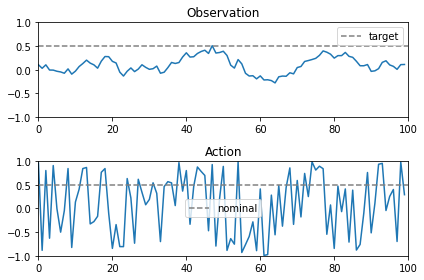

In [11]:
fig = plt.figure()
createView(fig, observation0, action0)

Envrionments controlled by trained agents follow a target:

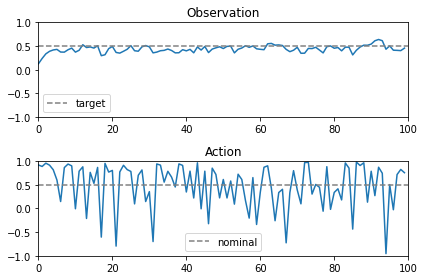

In [12]:
fig = plt.figure()
createView(fig, observation1, action1)